<a href="https://colab.research.google.com/github/Jash-Bhatia/Deep_Learning/blob/main/DeepLearning_Project/DL_Project_Bird_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import os
import shutil
import glob
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

In [2]:
!mkdir '/content/dataset'

In [3]:
path = '/content/drive/MyDrive/Sem_6/Deep Learning/Project/consolidated.zip'
import zipfile
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [7]:
PATH = "/content/dataset"

In [8]:
classes = os.listdir('/content/dataset')
len(classes)

260

In [9]:
images = []
label = []
for bird in classes:
    x = os.listdir(PATH+'/'+bird)
    for i in x:
        images.append(bird+'_'+i)
        label.append(bird)

In [10]:
df_train = pd.DataFrame(list(zip(images, label)), columns=['Image', 'Bird'])

In [ ]:
df_train.head()

In [11]:
batch_size = 64
train_input_shape = (224, 224, 3)
n_classes = len(classes)

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.15,
                                   zoom_range=0.5,
                                   #horizontal_flip=True,
                                   #vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=PATH,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=classes
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=PATH,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=classes
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 31469 images belonging to 260 classes.
Found 7740 images belonging to 260 classes.
Total number of batches = 491 and 120


In [28]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(1024, kernel_initializer='he_uniform')(X)
X = Dropout(0.4)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = Dropout(0.4)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(256, kernel_initializer='he_uniform')(X)
X = Dropout(0.4)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# X = Dense(16, kernel_initializer='he_uniform')(X)
# X = Dropout(0.4)(X)
# X = BatchNormalization()(X)
# X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.summary()

In [29]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [30]:
n_epoch = 15

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, 
                              verbose=1, mode='auto')

In [31]:
# Train the model - all layers
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16
                             )


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
491/491 [==============================] - 474s 935ms/step - loss: 5.4503 - accuracy: 0.0299 - val_loss: 5.5201 - val_accuracy: 0.0148
Epoch 2/15
491/491 [==============================] - 467s 931ms/step - loss: 4.0762 - accuracy: 0.2789 - val_loss: 3.6010 - val_accuracy: 0.5008
Epoch 3/15
491/491 [==============================] - 467s 932ms/step - loss: 2.8683 - accuracy: 0.5387 - val_loss: 1.9495 - val_accuracy: 0.7092
Epoch 4/15
491/491 [==============================] - 468s 933ms/step - loss: 1.9406 - accuracy: 0.7119 - val_loss: 1.1477 - val_accuracy: 0.7809
Epoch 5/15
491/491 [==============================] - 466s 929ms/step - loss: 1.3018 - accuracy: 0.8120 - val_loss: 0.9096 - val_accuracy: 0.8220
Epoch 6/15
491/491 [==============================] - 463s 922ms/step - loss: 0.8963 - accuracy: 0.8652 - val_loss: 0.8110 - val_accuracy: 0.8275
Epoch 7/15
491/491 [==============================] - 464s 926ms/step - loss: 0.6728 - accuracy: 0.8934 - val_loss: 0.6525 -

In [32]:
model.save_weights(filepath = '/content/drive/MyDrive/res_bird_model_weights.h5', overwrite = True)
model.save(filepath = '/content/drive/MyDrive/res_bird_model.h5', overwrite = True)

In [34]:
# Freeze core ResNet layers and train again 
for layer in model.layers[-6:]:
   layer.trainable = False

for layer in model.layers:
    layer.trainable = True

optimizer = Adam(lr=0.0005)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 5
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16                             
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
491/491 [==============================] - 504s 993ms/step - loss: 1.2011 - accuracy: 0.7334 - val_loss: 1.7433 - val_accuracy: 0.6310
Epoch 2/5
491/491 [==============================] - 496s 988ms/step - loss: 0.9636 - accuracy: 0.7733 - val_loss: 1.3677 - val_accuracy: 0.7060
Epoch 3/5
491/491 [==============================] - 497s 991ms/step - loss: 0.8140 - accuracy: 0.8067 - val_loss: 1.4194 - val_accuracy: 0.6906
Epoch 4/5
491/491 [==============================] - 473s 940ms/step - loss: 0.6706 - accuracy: 0.8361 - val_loss: 1.7958 - val_accuracy: 0.6238

Epoch 00004: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 5/5
491/491 [==============================] - 483s 962ms/step - loss: 0.4651 - accuracy: 0.8894 - val_loss: 0.4017 - val_accuracy: 0.9081


In [35]:
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']

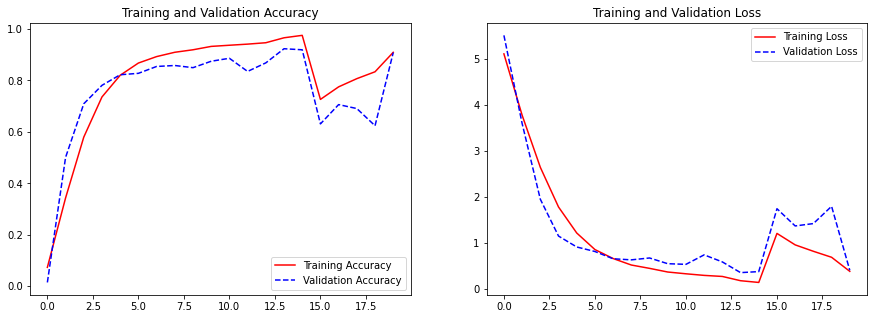

In [38]:
import matplotlib.pyplot as plt
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

In [39]:
score = model.evaluate_generator(valid_generator)
print("Prediction accuracy on CV data =", score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Prediction accuracy on CV data = 0.9025839567184448


In [36]:
model.save_weights(filepath = '/content/drive/MyDrive/bird_model_weights.h5', overwrite = True)

In [37]:
model.save(filepath = '/content/drive/MyDrive/bird_model.h5', overwrite = True)